# Визуализация сверточных нейросетей

In [2]:
# Подключаем библиотеки
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.models import Model, model_from_json
from tensorflow.python.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.python.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
%matplotlib inline

Using TensorFlow backend.


# Выбираем фото для демонстрации

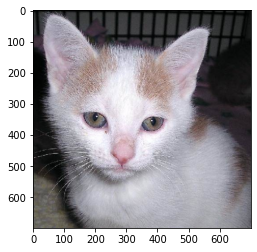

In [3]:
# image_file_name = 'test\dogs\dog.10632.jpg'
image_file_name = 'test\cats\cat.10724.jpg'
img = image.load_img(image_file_name, target_size=(700, 700))
plt.imshow(img)

# Преобразуем фотографию в массив numpy

In [4]:
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.

# Загружаем обученную модель VGG16

In [5]:
json_file = open('dogs-vs-cats-modelVGG16.json', "r")
loaded_model = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model)
loaded_model.load_weights('dogs-vs-cats-modelVGG16.h5')
# loaded_model.summary()

# Из модели выбираем первый слой (Сеть vgg16)
vgg16_layer = loaded_model.layers[0]
vgg16_layer.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

# Визуализация сети VGG16

In [6]:
# Обрезка модели на первом сверточном слое
vgg16_layer_0 = Model(inputs=vgg16_layer.input, outputs=vgg16_layer.layers[0].output)

# Обрезка модели на втором сверточном слое
vgg16_layer_1 = Model(inputs=vgg16_layer.input, outputs=vgg16_layer.layers[1].output)

# Обрезка для последнего слоя не нужна, так как модель заканчивается им

In [7]:
vgg16_layer_0.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [8]:
vgg16_layer_1.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
Total params: 1,792
Trainable params: 0
Non-trainable params: 1,792
_________________________________________________________________


In [9]:
# Предсказание для 0-го слоя
vgg16_layer_0_prediction = vgg16_layer_0.predict(img_array)

# Предсказание для 1-го слоя
vgg16_layer_1_prediction = vgg16_layer_1.predict(img_array)

# Предсказание для последнего слоя
vgg16_layer_last_prediction = vgg16_layer.predict(img_array)

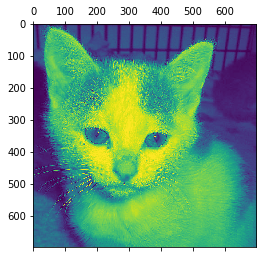

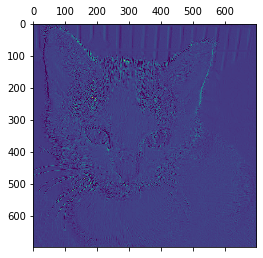

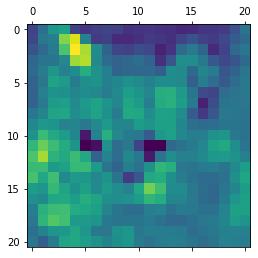

In [10]:
# В 0-м слое 3 конечные карты признака, в 1-м их 64, в последнем - 512

# Вывод по одной карте признака для каждого из слоев
plt.matshow(vgg16_layer_0_prediction[0, :, :, 2], cmap='viridis')
plt.matshow(vgg16_layer_1_prediction[0, :, :, 63], cmap='viridis')
plt.matshow(vgg16_layer_last_prediction[0, :, :, 510], cmap='viridis')

In [11]:
# функция для заполнения выходной решетки признаков
def GetFeatureGrid(images_per_row, size, n_cols, prediction):
    display_grid = np.zeros((n_cols* size, images_per_row * size))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = prediction[0, :, :, col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
    return display_grid

# Построение решетки признаков для 0-го 1-го и последних слоев

In [12]:
# размер выходной решетки 0-го слоя
images_per_row_0 = 3
n_filters_0 = vgg16_layer_0_prediction.shape[-1]
size_0 = vgg16_layer_0_prediction.shape[1]
n_cols_0 = n_filters_0 // images_per_row_0

# размер выходной решетки 1-го слоя
images_per_row_1 = 16
n_filters_1 = vgg16_layer_1_prediction.shape[-1]
size_1 = vgg16_layer_1_prediction.shape[1]
n_cols_1 = n_filters_1 // images_per_row_1

# размер выходной решетки последнего слоя
images_per_row_last = 16
n_filters_last = vgg16_layer_last_prediction.shape[-1]
size_last = vgg16_layer_last_prediction.shape[1]
n_cols_last = n_filters_last // images_per_row_last

In [13]:
# заполнение решетки 0-го слоя
display_grid_0 = GetFeatureGrid(images_per_row_0, size_0, n_cols_0, vgg16_layer_0_prediction)

# заполнение решетки 1-го слоя
display_grid_1 = GetFeatureGrid(images_per_row_1, size_1, n_cols_1, vgg16_layer_1_prediction)

# заполнение решетки последнего слоя
display_grid_last = GetFeatureGrid(images_per_row_last, size_last, n_cols_last, vgg16_layer_last_prediction)

<ipython-input-11-baa52c8a824a>:8: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


In [17]:
# функция для отображения решетки признаков
def ShowFeatureGrid(size, grid, scale_param):
    # Размер изображения
    scale = scale_param / size

    # Построение фигуры
    plt.figure(figsize=(scale * grid.shape[1], scale * grid.shape[0]))

    # Не отображать решетку
    plt.grid(False)

    # Показ фигуры
    plt.imshow(grid, aspect='auto', cmap='viridis')

# Визуализация 0-го слоя

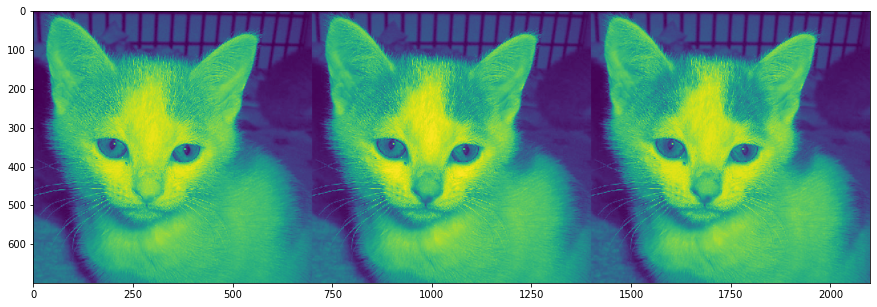

In [18]:
ShowFeatureGrid(size_0, display_grid_0, 5.)

# Визуализация 1-го слоя

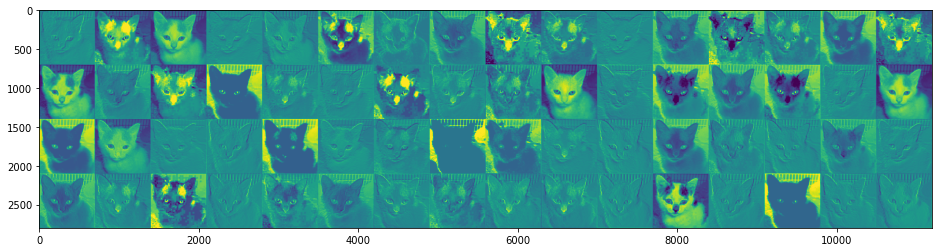

In [20]:
ShowFeatureGrid(size_1, display_grid_1, 1.)

# Визуализация последнего слоя

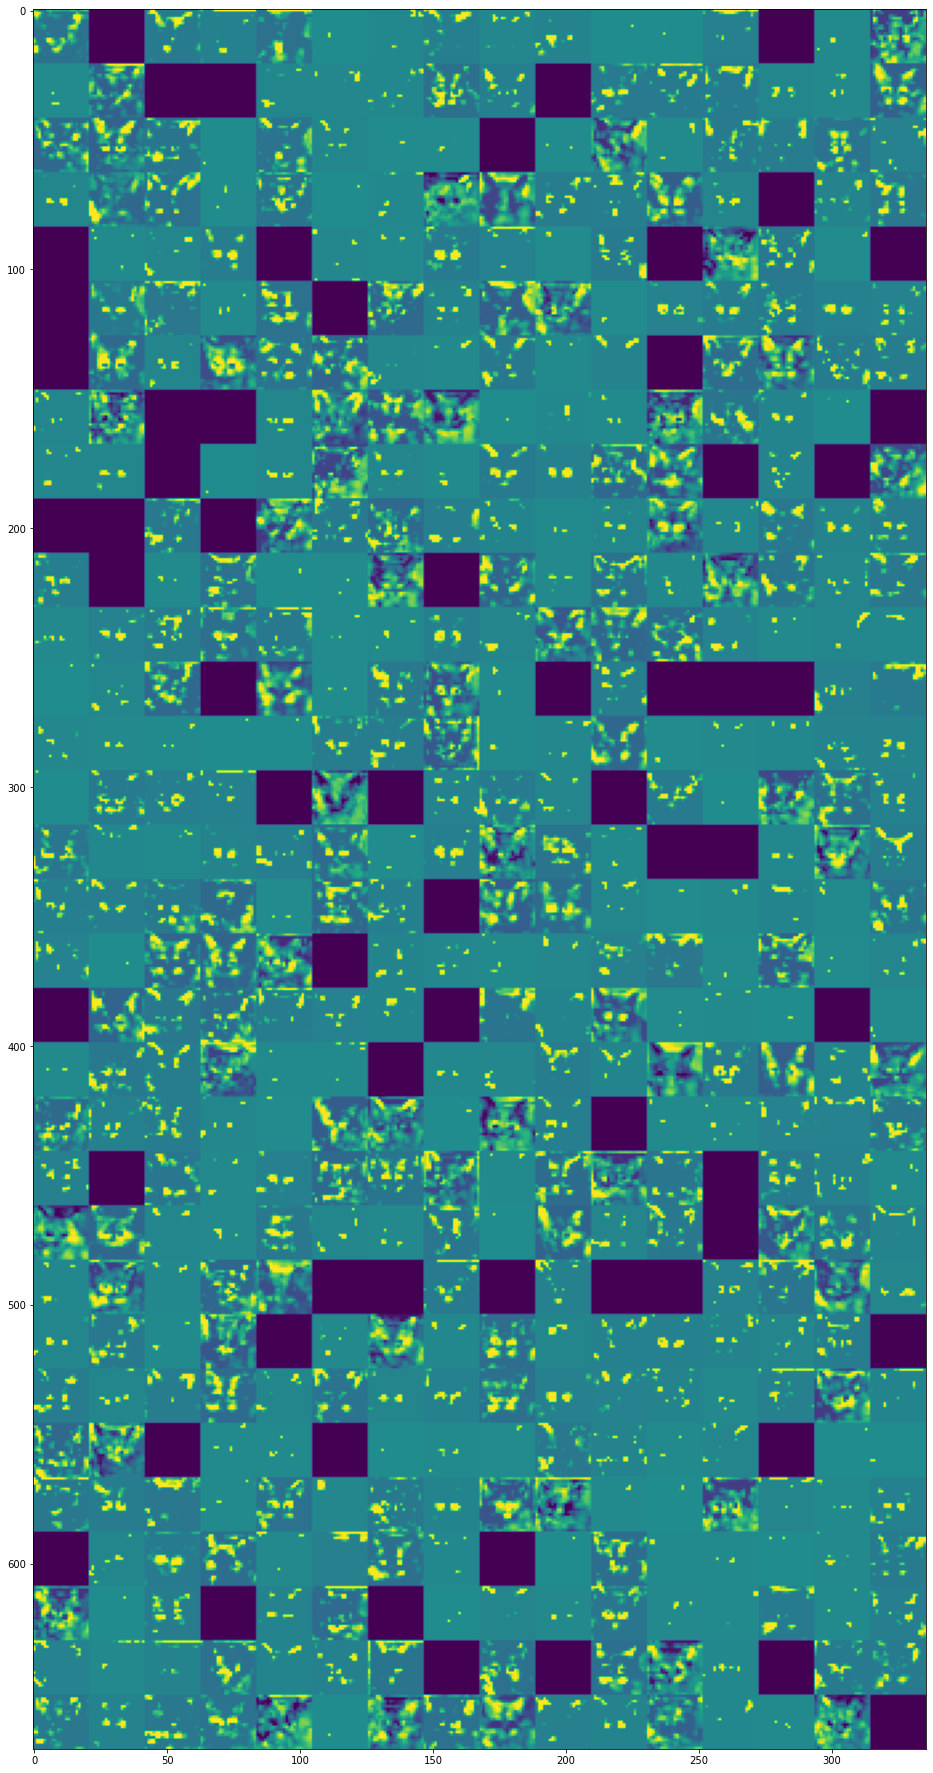

In [21]:
ShowFeatureGrid(size_last, display_grid_last, 1.)